**Author :** Rutendo F. Sigauke

**Input  :** 

1. Further filtered significant pairs

2. Bidirectiona annotations 

        - hg38_tfit_dreg_bidirectionals.bed

3. Gene and bidirectional pairs that overlap GTEx eQTLs 
    
        - sig_pairs_path_DT_filt_gtex_all_INTER.txt.gz
        
**Output :**

1. Figures (example pairs)

# Load libraries

In [1]:
suppressMessages(library(plotgardener))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(TxDb.Hsapiens.UCSC.hg38.knownGene))

# Functions

## Filter significant pairs

In [2]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, number_observed=10) {
    #' Remove pairs where the bidirectionals transcript is Downstream of Polyadenylation Site (DoPAD)
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, abs(distance_tes) < dist_DoPAD)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
    
}

## Get pairs for plotting

In [3]:
get_pairs_bed6 <- function(sig_pairs, sig_pairs_gtex, gene){
    
    
    ##all pairs
    sig_pairs_geneID <- subset(sig_pairs, transcript_1==gene)
    sig_pairs_geneID$pairID <- paste0(sig_pairs_geneID$transcript_1, 
                                      '~',
                                      sig_pairs_geneID$transcript_2)
    
    ##pairs that overlap GTEx pairs
    sig_pairs_gtex_geneID <- subset(sig_pairs_gtex, transcript_1==gene)
    sig_pairs_gtex_geneID$pairID <- paste0(sig_pairs_gtex_geneID$transcript_1,
                                           '~',
                                           sig_pairs_gtex_geneID$transcript_2)
    
    sig_pairs_geneID_no_gtex <- sig_pairs_geneID[!sig_pairs_geneID$pairID 
                                                 %in%
                                                 sig_pairs_gtex_geneID$pairID,]

    ##add column for wether pair is in GTEx
    sig_pairs_geneID_no_gtex$gtex <- 0
    sig_pairs_gtex_geneID$gtex <- 1
    
    ##combine the pairs
    sig_pairs_final <- rbind(unique(sig_pairs_geneID_no_gtex[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop',
                                                                'gtex')]), 
                              unique(sig_pairs_gtex_geneID[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop',
                                                                'gtex')]))


    sig_pairs_final$length <- abs(sig_pairs_final$transcript2_start - sig_pairs_final$transcript1_start) / 1000
    return(sig_pairs_final)
    
}

In [4]:
get_pairs_pcc_bed6 <- function(sig_pairs, sig_pairs_gtex, gene){
    
    ##get all pairs for a gene
    sig_pairs_geneID <- subset(sig_pairs, transcript_1==gene)
    
    strand <- unique(sig_pairs_geneID$transcript1_strand)
    
    ##annotate the TSS start plis 1 for the 
    if (strand == "+"){
        
        sig_pairs_geneID$transcript1_stop <- sig_pairs_geneID$transcript1_start + 1
        
    } else{
        
        sig_pairs_geneID$transcript1_start <- sig_pairs_geneID$transcript1_stop - 1
    }
    
    ##get the center coordinate for bidirectionals
    sig_pairs_geneID$transcript2_start <- round((sig_pairs_geneID$transcript2_start + sig_pairs_geneID$transcript2_stop)/2)
    sig_pairs_geneID$transcript2_stop <- sig_pairs_geneID$transcript2_start +1
    
    sig_pairs_geneID$pairID <- paste0(sig_pairs_geneID$transcript_1, 
                                      '~',
                                      sig_pairs_geneID$transcript_2)
    
    ##pairs that overlap GTEx pairs
    sig_pairs_gtex_geneID <- subset(sig_pairs_gtex, transcript_1==gene)
    sig_pairs_gtex_geneID$pairID <- paste0(sig_pairs_gtex_geneID$transcript_1,
                                           '~',
                                           sig_pairs_gtex_geneID$transcript_2)
    
    sig_pairs_geneID_no_gtex <- sig_pairs_geneID[!sig_pairs_geneID$pairID 
                                                 %in%
                                                 sig_pairs_gtex_geneID$pairID,]

    ##add column for wether pair is in GTEx
    sig_pairs_geneID_no_gtex$gtex <- 0
    sig_pairs_gtex_geneID$gtex <- 1
    
    ##combine the pairs
    sig_pairs_final <- rbind(unique(sig_pairs_geneID_no_gtex[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop','pcc',
                                                                'gtex')]), 
                              unique(sig_pairs_gtex_geneID[,c('transcript1_chrom','transcript1_start',
                                                                'transcript1_stop', 'transcript2_chrom',
                                                                'transcript2_start','transcript2_stop','pcc',
                                                                'gtex')]))

    sig_pairs_final$length <- abs(sig_pairs_final$transcript2_start - sig_pairs_final$transcript1_start) / 1000
    sig_pairs_final$pcc <- abs(sig_pairs_final$pcc)
    return(sig_pairs_final)
    
}

# Interactions from DBNascent

## Load in the pairs

In [5]:
sig_pairs_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/significant'

##get paths for the counts tables
sig_pairs_path_files <- list.files(path=sig_pairs_path, 
                              pattern="*gz", 
                                   full.names=TRUE)

##load correlations
sig_pairs_path_DT_list <- lapply(sig_pairs_path_files, 
                                   data.table::fread) 


In [6]:
##combine to one data.table
sig_pairs_path_DT <- do.call(rbind, sig_pairs_path_DT_list)
dim(sig_pairs_path_DT)
head(sig_pairs_path_DT, 2)

[1] 3663224      22

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,pcc,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33036652,33037238,chr1:33036652-33037238,⋯,-0.6346208,1.238535e-25,9.631487e-23,215,11.984604,284153,269820,downstream,blood,96.846847
chr1,33306765,33321098,A3GALT2:NM_001080438.1,.,-,chr1,33224694,33224966,chr1:33224694-33224966,⋯,0.8022481,1.846433e-04,2.198101e-03,16,5.028114,96268,81935,downstream,blood,7.207207


In [7]:
sig_pairs_path_DT_filt <- removing_DoPAD_bidirs(sig_pairs_path_DT)
nrow(sig_pairs_path_DT_filt)

[1] 1440890

## GTEx overlaps

In [8]:
sig_pairs_path_DT_filt_gtex_all <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gtex_bidir_significant_pairs/sig_pairs_path_DT_filt_gtex_all_INTER.txt.gz",
                                                     sep='\t')

nrow(sig_pairs_path_DT_filt_gtex_all)
head(sig_pairs_path_DT_filt_gtex_all, 2)

[1] 121132

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,gtex
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<int>
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94310249,94311127,chr1:94310249-94311127,⋯,4.657652e-06,21,8.106376,-107700,-168035,upstream,blood,9.459459,ABCD3:NM_001122674.2~chr1:94310249-94311127,1
chr1,94418388,94478723,ABCD3:NM_001122674.2,.,+,chr1,94347033,94348559,chr1:94347033-94348559,⋯,3.478977e-06,22,8.085675,-70592,-130927,upstream,blood,9.909910,ABCD3:NM_001122674.2~chr1:94347033-94348559,1


## Load bidirectionals

In [9]:
hg38_bidirs <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38_tfit_dreg_bidirectionals.bed")
colnames(hg38_bidirs) <- c('chrom','start','end','id','score','strand')
nrow(hg38_bidirs)
head(hg38_bidirs, 2)


[1] 847521

chrom,start,end,id,score,strand
<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,3917,4919,dreg,14,.
chr1,5632,6042,dreg,14,.


# Plot arches

## HCG18

In [10]:
sig_pairs_hcg18 <- get_pairs_pcc_bed6(sig_pairs_path_DT_filt,
                                  sig_pairs_path_DT_filt_gtex_all, 
                                  "HCG18:NR_024052.2")
nrow(sig_pairs_hcg18)
head(sig_pairs_hcg18)

[1] 140

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,30327155,30327156,chr6,29645735,29645736,0.7665438,0,681.420
chr6,30327155,30327156,chr6,29834438,29834439,0.7045619,0,492.717
chr6,30327155,30327156,chr6,30118200,30118201,0.8913380,0,208.955
chr6,30327155,30327156,chr6,30412089,30412090,0.7335451,0,84.934
chr6,30327155,30327156,chr6,30482219,30482220,0.6785790,0,155.064
chr6,30327155,30327156,chr6,30869693,30869694,0.8846988,0,542.538


In [11]:
30327156-1000000
30327156+1000000

[1] 29327156

[1] 31327156

In [12]:
sig_pairs_hcg18_gtex <- subset(sig_pairs_hcg18, gtex==1)
nrow(sig_pairs_hcg18_gtex)
head(sig_pairs_hcg18_gtex, 2)

[1] 90

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,30287396,30327156,chr6,29487990,29488570,0.7993624,1,799.406
chr6,30287396,30327156,chr6,29647641,29648589,0.6746169,1,639.755


Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]



genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



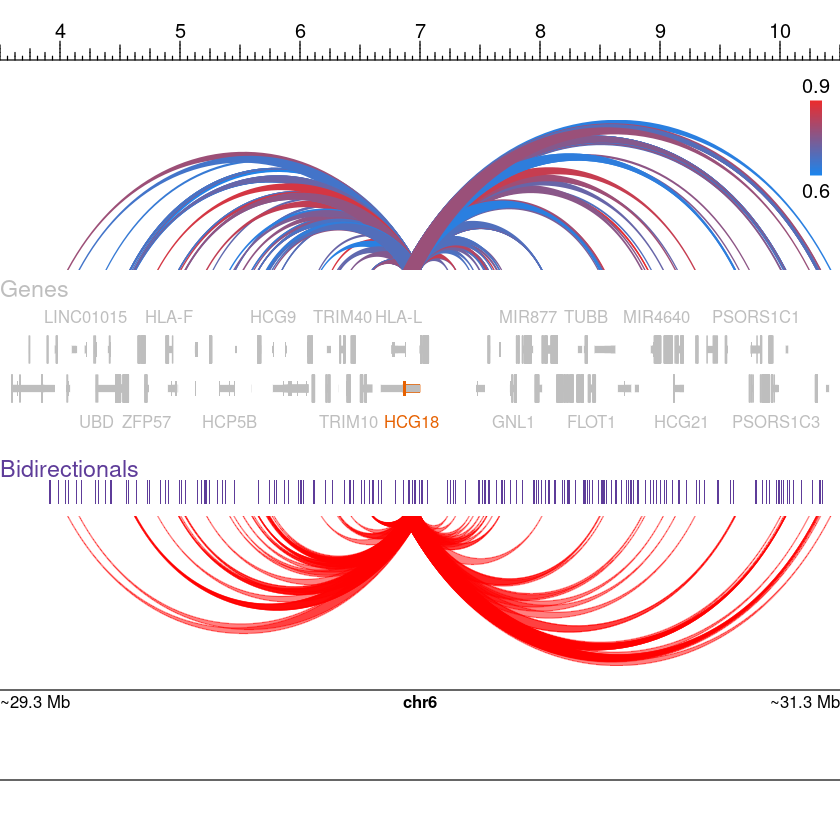

In [13]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_hcg18$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_hcg18_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18$length / max(sig_pairs_hcg18$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("HCG18"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectionals", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18_gtex,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18_gtex$length / max(sig_pairs_hcg18_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)




In [14]:
hcg18_gtex_Npairs <- nrow(unique(sig_pairs_hcg18_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of HCG18 GTEx pairs =", hcg18_gtex_Npairs))

[1] "Number of HCG18 GTEx pairs = 63"


In [15]:
hcg18_Npairs <- nrow(unique(sig_pairs_hcg18[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of HCG18 ALL pairs =", hcg18_Npairs))

[1] "Number of HCG18 ALL pairs = 96"


In [16]:
hcg18_perc_gtex_pairs <- (hcg18_gtex_Npairs/hcg18_Npairs)*100
print(paste("Percent HCG18 GTEx pairs =", 
            signif(hcg18_perc_gtex_pairs,4),
            "%"))

[1] "Percent HCG18 GTEx pairs = 65.62 %"


In [17]:
pdf(file = "/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/hcg18_links_arches_plot.pdf", 
    width = 14,
    height = 6)


pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_hcg18$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_hcg18_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18$length / max(sig_pairs_hcg18$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("HCG18"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectionals", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_hcg18_gtex,
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_hcg18_gtex$length / max(sig_pairs_hcg18_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 29327156, chromend = 31327156,
    assembly = "hg38",
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)

dev.off()

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



png 
  2

## GABBR1

In [18]:
sig_pairs_gabbr1 <- get_pairs_pcc_bed6(sig_pairs_path_DT_filt,
                                  sig_pairs_path_DT_filt_gtex_all, 
                                  "GABBR1:NM_021903.3")
nrow(sig_pairs_gabbr1)
head(sig_pairs_gabbr1, 2)

[1] 186

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,29628012,29628013,chr6,28635456,28635457,0.7621376,0,992.556
chr6,29628012,29628013,chr6,28639188,28639189,0.7959106,0,988.824


In [19]:
sig_pairs_gabbr1_gtex <- subset(sig_pairs_gabbr1, gtex==1)
nrow(sig_pairs_gabbr1_gtex)
head(sig_pairs_gabbr1_gtex, 2)

[1] 68

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr6,29602237,29628013,chr6,28654595,28656485,0.8175136,1,947.642
chr6,29602237,29628013,chr6,28689626,28689940,0.6427015,1,912.611


In [20]:
29628013-1000000
29628013+1000000

[1] 28628013

[1] 30628013

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



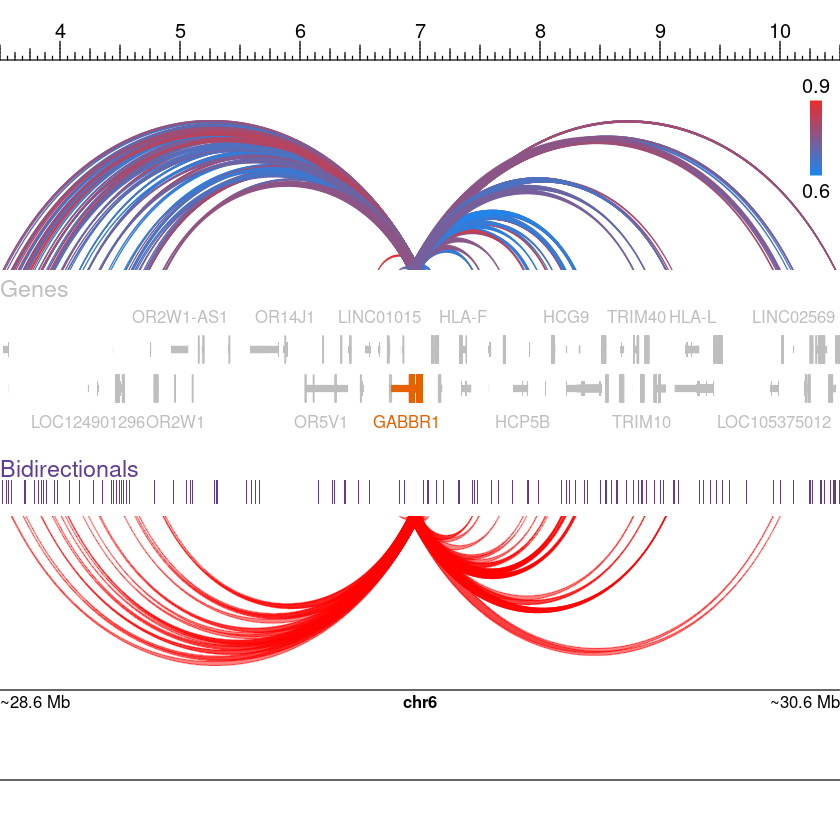

In [21]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_gabbr1$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_gabbr1_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_gabbr1,
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_gabbr1$length / max(sig_pairs_gabbr1$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("GABBR1"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectionals", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_gabbr1_gtex,
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_gabbr1_gtex$length / max(sig_pairs_gabbr1_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr6", chromstart = 28628013, chromend = 30628013,
    assembly = "hg38",
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)

In [22]:
gabbr1_gtex_Npairs <- nrow(unique(sig_pairs_gabbr1_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of GABBR1 GTEx pairs =", gabbr1_gtex_Npairs))

[1] "Number of GABBR1 GTEx pairs = 51"


In [23]:
gabbr1_Npairs <- nrow(unique(sig_pairs_gabbr1[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of GABBR1 ALL pairs =", gabbr1_Npairs))

[1] "Number of GABBR1 ALL pairs = 138"


In [24]:
gabbr1_perc_gtex_pairs <- (gabbr1_gtex_Npairs/gabbr1_Npairs)*100
print(paste("Percent GABBR1 GTEx pairs =", 
            signif(gabbr1_perc_gtex_pairs,4),
            "%"))

[1] "Percent GABBR1 GTEx pairs = 36.96 %"


## SUMO2

In [25]:
sig_pairs_sumo2 <- get_pairs_pcc_bed6(sig_pairs_path_DT_filt,
                                  sig_pairs_path_DT_filt_gtex_all, 
                                  "SUMO2:NM_006937.4")
nrow(sig_pairs_sumo2)
head(sig_pairs_sumo2)

[1] 84

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17,75182958,75182959,chr17,74325253,74325254,0.9072803,0,857.705
chr17,75182958,75182959,chr17,74374026,74374027,0.6137697,0,808.932
chr17,75182958,75182959,chr17,74403760,74403761,0.7086513,0,779.198
chr17,75182958,75182959,chr17,74504218,74504219,0.6802590,0,678.740
chr17,75182958,75182959,chr17,74505830,74505831,0.6172913,0,677.128
chr17,75182958,75182959,chr17,74657676,74657677,0.7678142,0,525.282


In [26]:
sig_pairs_sumo2_gtex <- subset(sig_pairs_sumo2, gtex==1)
nrow(sig_pairs_sumo2_gtex)
head(sig_pairs_sumo2_gtex, 2)

[1] 14

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr17,75165585,75182959,chr17,75198615,75198931,0.7444397,1,33.030
chr17,75165585,75182959,chr17,75198931,75199419,0.6750620,1,33.346


In [27]:
75182959-1000000
75182959+1000000

[1] 74182959

[1] 76182959

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



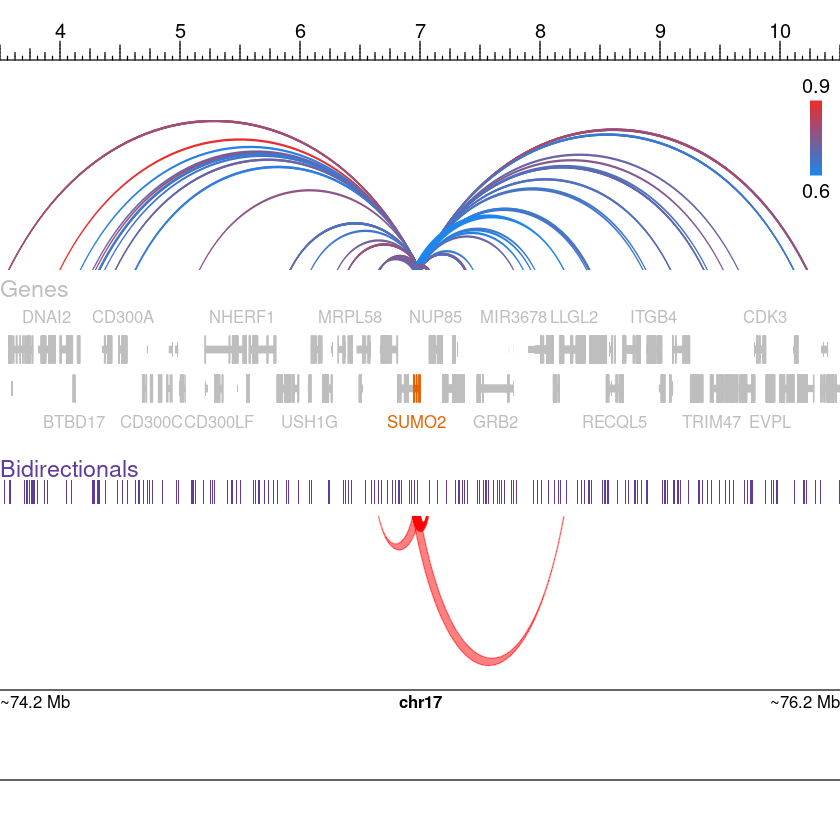

In [28]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_sumo2$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_sumo2_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_sumo2,
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_sumo2$length / max(sig_pairs_sumo2$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("SUMO2"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectionals", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_sumo2_gtex,
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_sumo2_gtex$length / max(sig_pairs_sumo2_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr17", chromstart = 74182959, chromend = 76182959,
    assembly = "hg38",
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)


In [29]:
sumo2_gtex_Npairs <- nrow(unique(sig_pairs_sumo2_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of SUMO2 GTEx pairs =", sumo2_gtex_Npairs))

[1] "Number of SUMO2 GTEx pairs = 8"


In [30]:
sumo2_Npairs <- nrow(unique(sig_pairs_sumo2[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of SUMO2 ALL pairs =", sumo2_Npairs))

[1] "Number of SUMO2 ALL pairs = 56"


In [31]:
sumo2_perc_gtex_pairs <- (sumo2_gtex_Npairs/sumo2_Npairs)*100
print(paste("Percent SUMO2 GTEx pairs =", 
            signif(sumo2_perc_gtex_pairs,4),
            "%"))

[1] "Percent SUMO2 GTEx pairs = 14.29 %"


## DRAM1

In [32]:
sig_pairs_dram1 <- get_pairs_pcc_bed6(sig_pairs_path_DT_filt,
                                  sig_pairs_path_DT_filt_gtex_all, 
                                  "DRAM1:NM_018370.3")
nrow(sig_pairs_dram1)
head(sig_pairs_dram1)

[1] 34

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr12,101877579,101877580,chr12,101857541,101857542,0.7327243,0,20.038
chr12,101877579,101877580,chr12,101859851,101859852,0.6876839,0,17.728
chr12,101877579,101877580,chr12,101982283,101982284,0.7029095,0,104.704
chr12,101877579,101877580,chr12,101857541,101857542,0.9021709,0,20.038
chr12,101877579,101877580,chr12,101859851,101859852,0.8654226,0,17.728
chr12,101877579,101877580,chr12,101230138,101230139,0.6034330,0,647.441


In [33]:
sig_pairs_dram1_gtex <- subset(sig_pairs_dram1, gtex==1)
nrow(sig_pairs_dram1_gtex)
head(sig_pairs_dram1_gtex, 2)

[1] 13

transcript1_chrom,transcript1_start,transcript1_stop,transcript2_chrom,transcript2_start,transcript2_stop,pcc,gtex,length
<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr12,101877579,101923612,chr12,101858530,101858820,0.6507177,1,19.049
chr12,101877579,101923612,chr12,101876342,101876790,0.7429669,1,1.237


In [34]:
101877579-1000000
101877579+1000000

[1] 100877579

[1] 102877579

Warning message:
“Not enough numerical values to map to colors without a range.”
arches[arches1]

heatmapLegend[heatmapLegend1]

genes[genes1]

text[text1]

ranges[ranges1]

text[text2]

arches[arches2]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



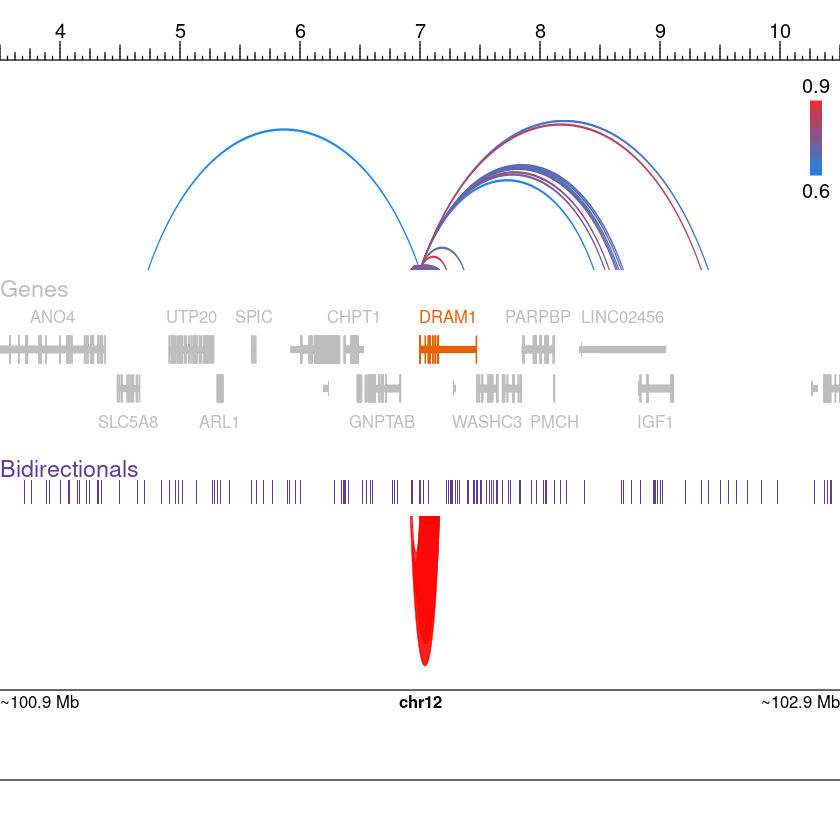

In [35]:
pageCreate(
    width = 14, height = 6, default.units = "inches",
    showGuides = TRUE, xgrid = 0, ygrid = 0
)

colors_pcc <- mapColors(vector = sig_pairs_dram1$pcc,
             palette = colorRampPalette(c("dodgerblue2", "firebrick2")))

colors <- mapColors(vector = sig_pairs_dram1_gtex$gtex,
                    palette = colorRampPalette(c("grey20","red")))


## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_dram1,
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    fill = colors_pcc,
    linecolor = "fill", 
    archHeight = sig_pairs_dram1$length / max(sig_pairs_dram1$length),
    alpha = 1,
    x = 3.5, y = 0.5, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Legend with color key
annoHeatmapLegend(
    plot = bedpePlot, fontcolor = "black",
    x = 10.25, y = 0.15,
    width = 0.10, height = 1, fontsize = 12
)

## Add gene track
plotGenes(
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    geneHighlights = data.frame(
        "gene" = c("DRAM1"),
        "color" = c("#e66101")
    ),
    fill="grey",
    fontcolor = "grey",
    geneBackground = "grey",
    fontsize = 10,
    x = 3.5, y = 1.95, width = 7, height = 1.25,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Genes", fontcolor = "grey", fontsize = 14,
    x = 3.5, y = 1.90, just = "left"
)

## add bidirectional track
pileupPlot <- plotRanges(
    data = hg38_bidirs, 
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    fill = "#5e3c99",
    collapse = TRUE,
    spaceWidth = 0.000002,
    spaceHeight = 0.00003,
    baseline.lwd = 0.25,
    x = 3.5, y = 3.50, width = 7, height = 0.2,
    just = c("left", "top"), default.units = "inches"
)

plotText(
    label = "Bidirectionals", fontcolor = "#5e3c99", fontsize = 14,
    x = 3.5, y = 3.4, just = "left"
)

## Arches for gene bidirectional pairs
bedpePlot <- plotPairsArches(
    data = sig_pairs_dram1_gtex,
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    fill = 'red',
    flip = TRUE,
    linecolor = "fill", 
    archHeight = sig_pairs_dram1_gtex$length / max(sig_pairs_dram1_gtex$length),
    alpha = 0.5,
    x = 3.5, y = 3.8, width = 7, height = 1.25,
    just = c("left", "top"),
    default.units = "inches"
)

## Plot genome label
plotGenomeLabel(
    chrom = "chr12", chromstart = 100877579, chromend = 102877579,
    assembly = "hg38",
    x = 3.5, y = 5.25, length = 7, scale = "Mb",
    just = c("left", "top"), default.units = "inches"
)

In [36]:
dram1_gtex_Npairs <- nrow(unique(sig_pairs_dram1_gtex[,c('transcript1_chrom',
                                                         'transcript1_start',
                                                         'transcript1_stop',
                                                         'transcript2_chrom',
                                                         'transcript2_start',
                                                         'transcript2_stop')]))

print(paste("Number of DRAM1 GTEx pairs =", dram1_gtex_Npairs))

[1] "Number of DRAM1 GTEx pairs = 4"


In [37]:
dram1_Npairs <- nrow(unique(sig_pairs_dram1[,c('transcript1_chrom',
                                               'transcript1_start',
                                               'transcript1_stop',
                                               'transcript2_chrom',
                                               'transcript2_start',
                                               'transcript2_stop')]))

print(paste("Number of DRAM1 ALL pairs =", dram1_Npairs))

[1] "Number of DRAM1 ALL pairs = 21"


In [38]:
dram1_perc_gtex_pairs <- (dram1_gtex_Npairs/dram1_Npairs)*100
print(paste("Percent DRAM1 GTEx pairs =", 
            signif(dram1_perc_gtex_pairs,4),
            "%"))

[1] "Percent DRAM1 GTEx pairs = 19.05 %"


# Session Information

In [39]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] TxDb.Hsapiens.UCSC.hg38.knownGene_3.17.0
 [2] GenomicFeatures_1.52.2                  
 [3] AnnotationDbi_1.62.2                    
 [4] Biobase_2.60.0                          
 [5] GenomicRanges_1.52.1                    
 [6] Genom